<a href="https://colab.research.google.com/github/mohammed-hakim/AI-ML-for-5G-Energy-Consumption-ZINDI-COMPETITION/blob/main/AI_ML_for_5G_Energy_Consumption_ZINDI_COMPETITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
razihamdi_zindi_compt_path = kagglehub.dataset_download('razihamdi/zindi-compt')

print('Data source import complete.')


Data source import complete.


In [66]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [67]:
bs_df=pd.read_csv(f"{razihamdi_zindi_compt_path}/imgs_2023071012123392536.csv")
cl_df=pd.read_csv(f"{razihamdi_zindi_compt_path}/imgs_2023071012130978799.csv")
ec_df=pd.read_csv(f"{razihamdi_zindi_compt_path}/imgs_2023071012133740345.csv")
pc_df=pd.read_csv(f"{razihamdi_zindi_compt_path}/imgs_202307101549519358.csv")
sample_submission=pd.read_csv(f"{razihamdi_zindi_compt_path}/SampleSubmission (4).csv")
sample_submission.head()

,ID,Energy
0,2023-01-01 06:00:00_B_0,0
1,2023-01-01 11:00:00_B_0,0
2,2023-01-01 12:00:00_B_0,0
3,2023-01-01 13:00:00_B_0,0
4,2023-01-01 23:00:00_B_0,0


In [68]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

In [70]:
pc_df = rename_columns(pc_df)
cl_df = rename_columns(cl_df)
bs_df = rename_columns(bs_df)
ec_df = rename_columns(ec_df)

In [71]:
cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pc_df['time'] = pd.to_datetime(pc_df['time'])

In [72]:
cl_bs_df = cl_df.merge(bs_df, on=['bs', 'cellname'], how='left')
cl_bs_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934


In [73]:
cl_bs_df[cl_bs_df['bs'] == 'B_0']

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118787,2023-01-02 19:00:00,B_0,Cell1,0.206135,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118788,2023-01-02 20:00:00,B_0,Cell1,0.152981,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118789,2023-01-02 21:00:00,B_0,Cell1,0.150808,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118790,2023-01-02 22:00:00,B_0,Cell1,0.289731,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504


In [74]:
cl_bs_df.groupby("bs")['cellname'].nunique()

,cellname
bs,
B_0,2
B_1,1
B_10,2
B_100,1
B_1000,1
...,...
B_995,1
B_996,1
B_997,1


In [75]:
cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

,count
cellname,
1,827
2,191
4,2


In [76]:
cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs'],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'frequency',
       'bandwidth', 'antennas', 'txpower'],
).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)
cl_bs_df = cl_bs_df.merge(bs_df.groupby('bs')[['rutype', 'mode']].first().reset_index(), on='bs', how='left')



In [77]:
cl_bs_df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2


In [78]:
df = cl_bs_df.merge(ec_df, on=['time', 'bs'], how='left')

In [79]:
df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode,energy
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,64.275037
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2,18.086697
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,30.343797
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,NaN
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,15.545590


In [80]:
df['energy'].isna().value_counts()

,count
energy,
False,92629
True,26139


In [81]:
df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')

# EDA

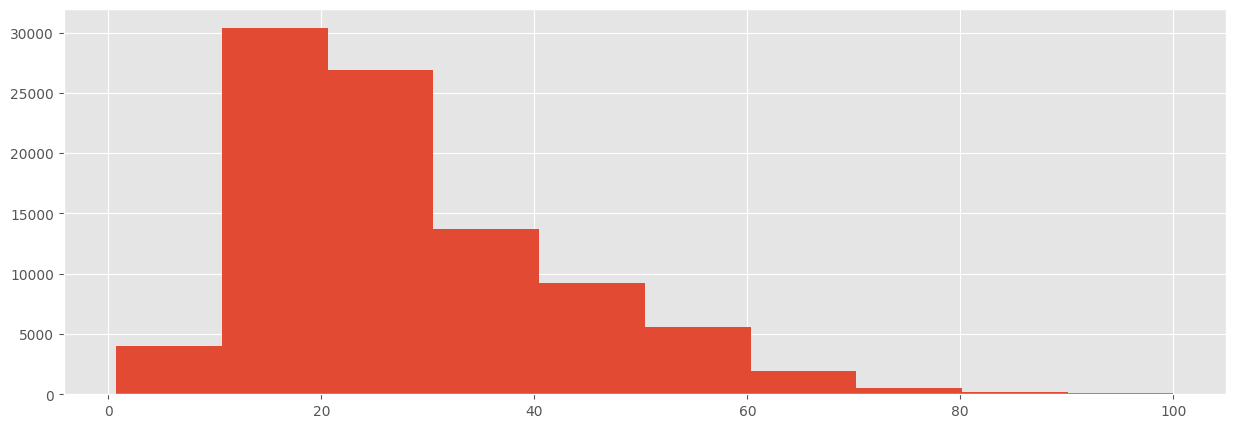

In [82]:
plt.figure(figsize=(15, 5))
df['energy'].hist()
plt.show()

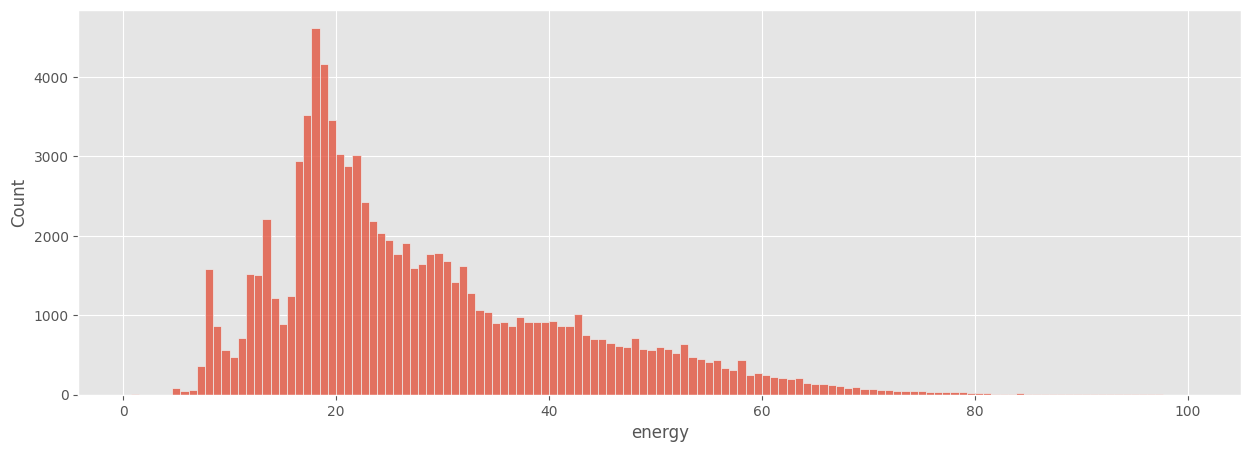

In [83]:
plt.figure(figsize=(15, 5))
sns.histplot(df['energy'])
plt.show()

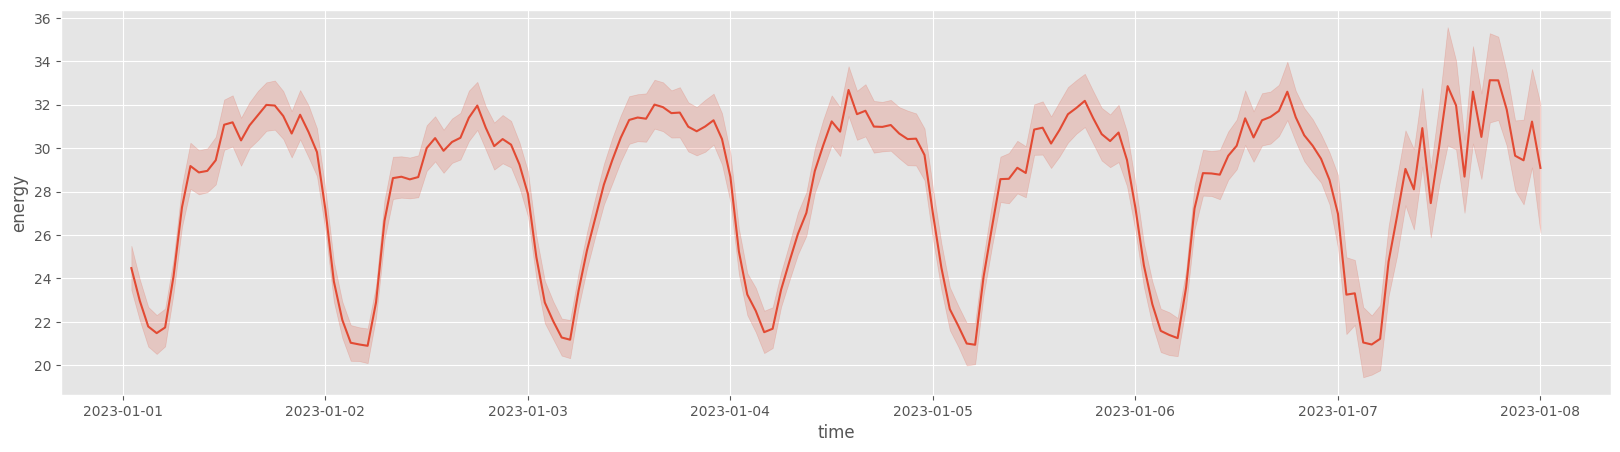

In [84]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy')
plt.show()

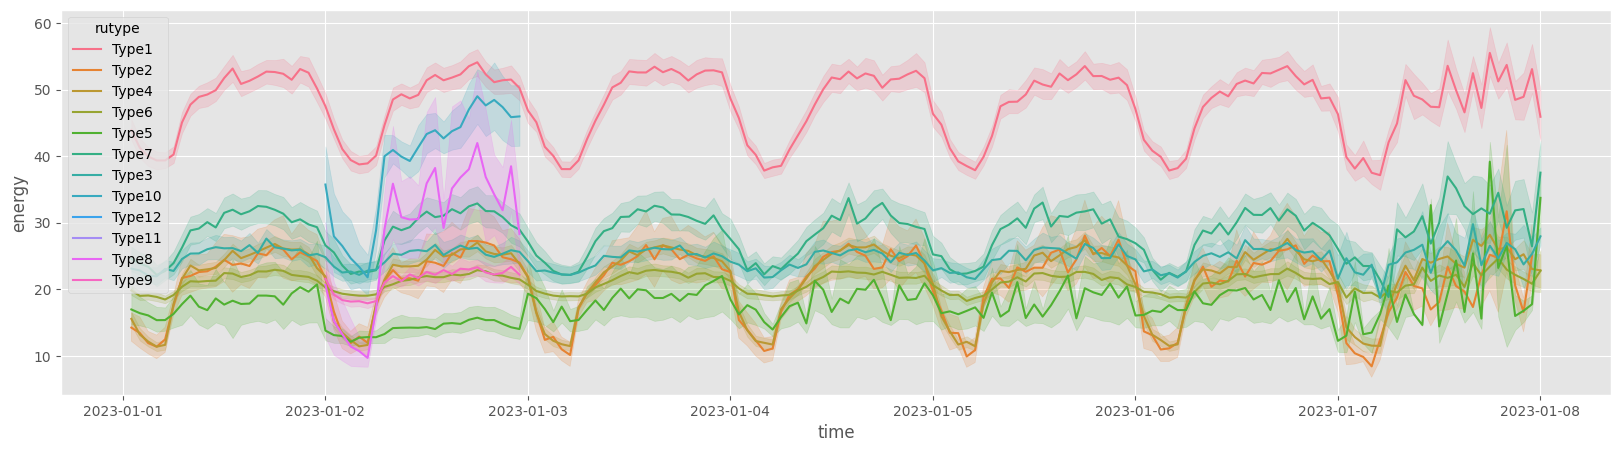

In [85]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='rutype')
plt.show()

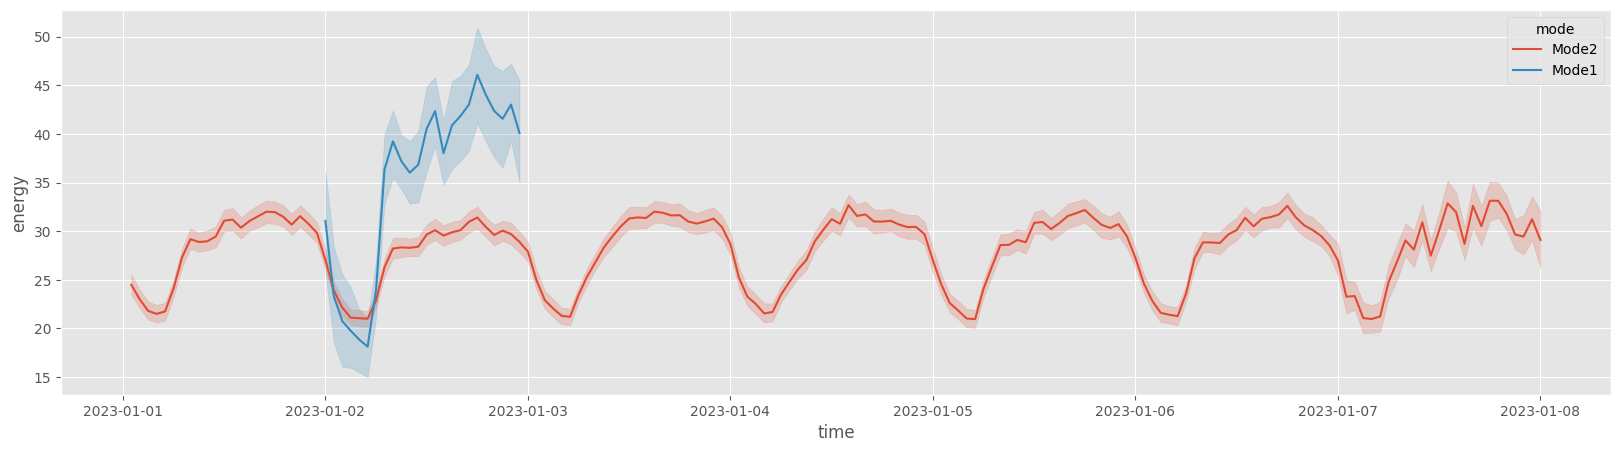

In [86]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='mode')
plt.show()

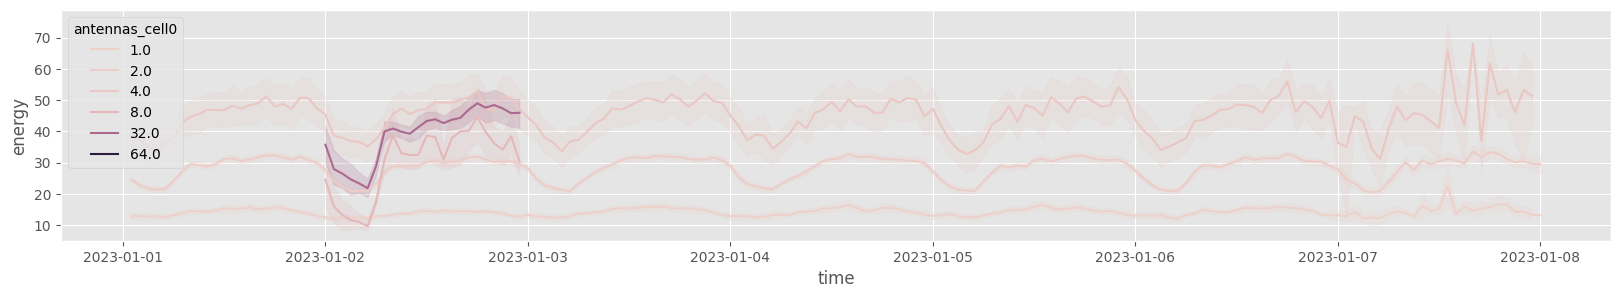

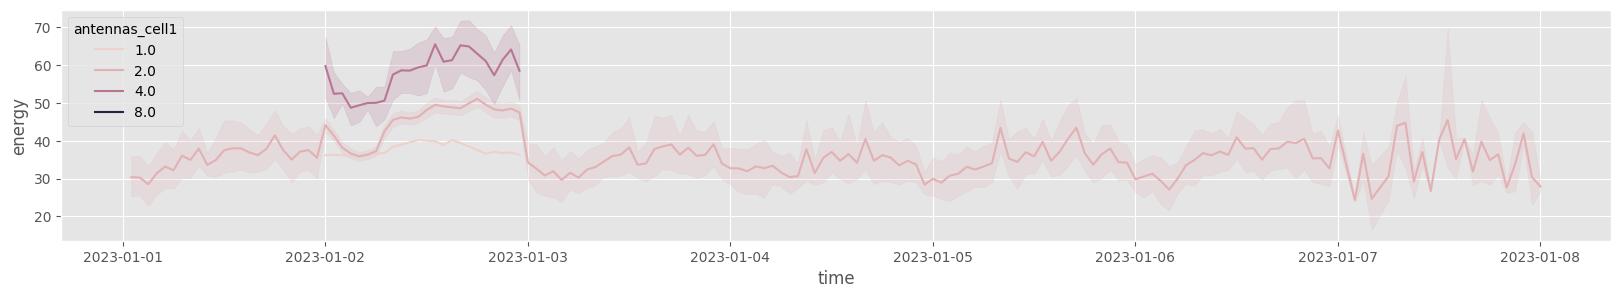

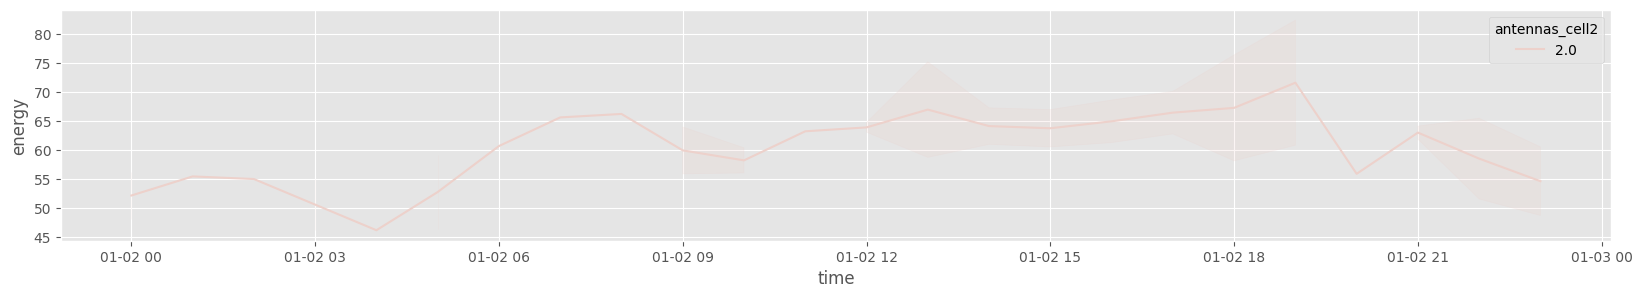

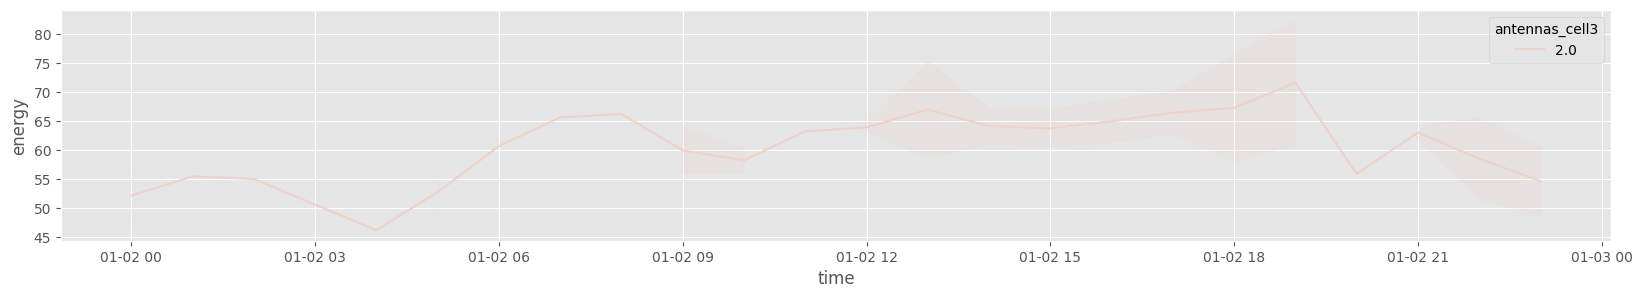

In [87]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell3')
plt.show()

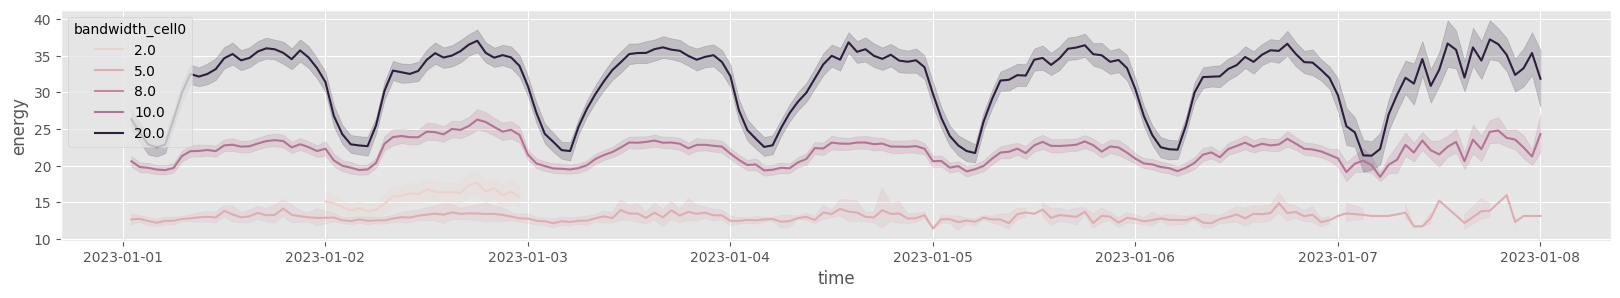

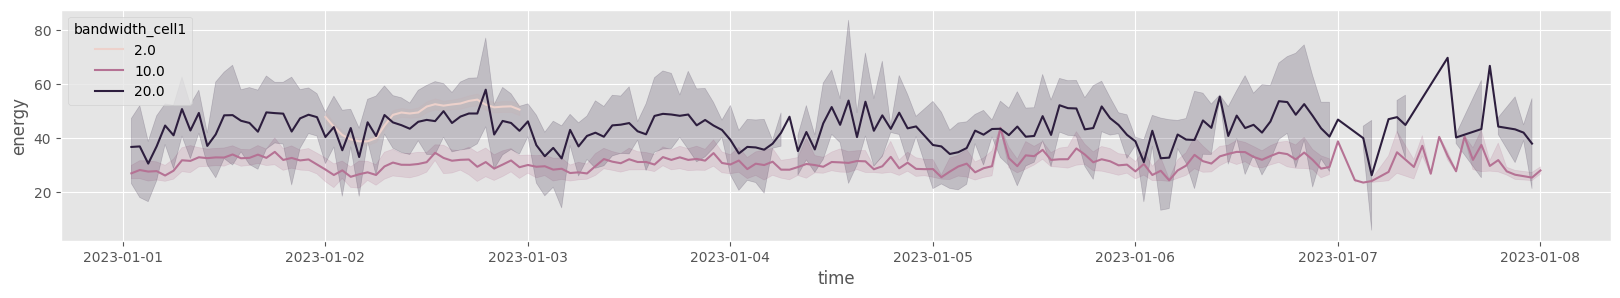

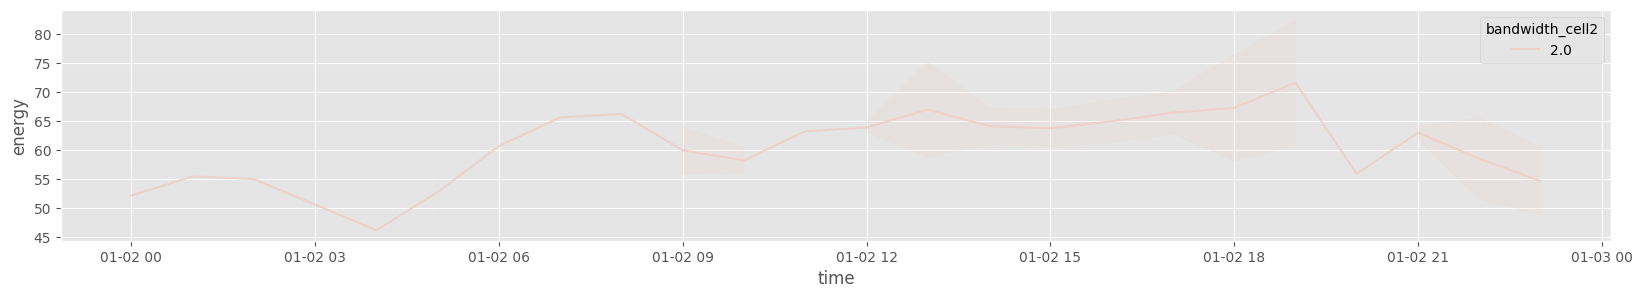

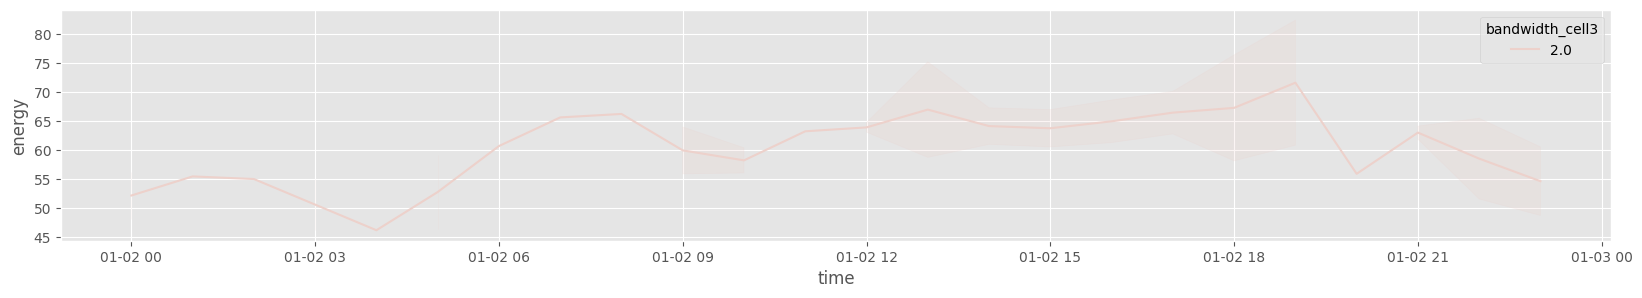

In [88]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell3')
plt.show()

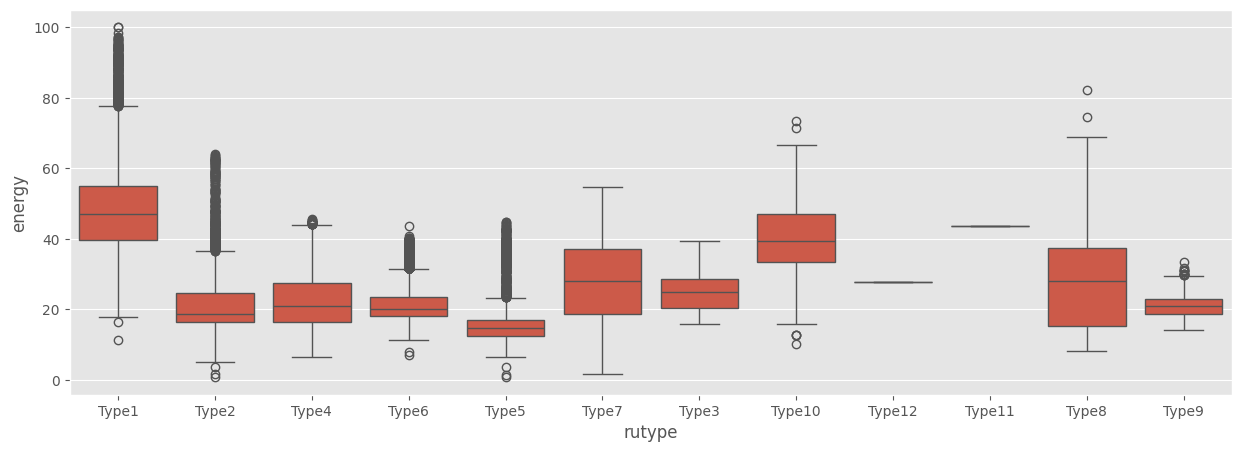

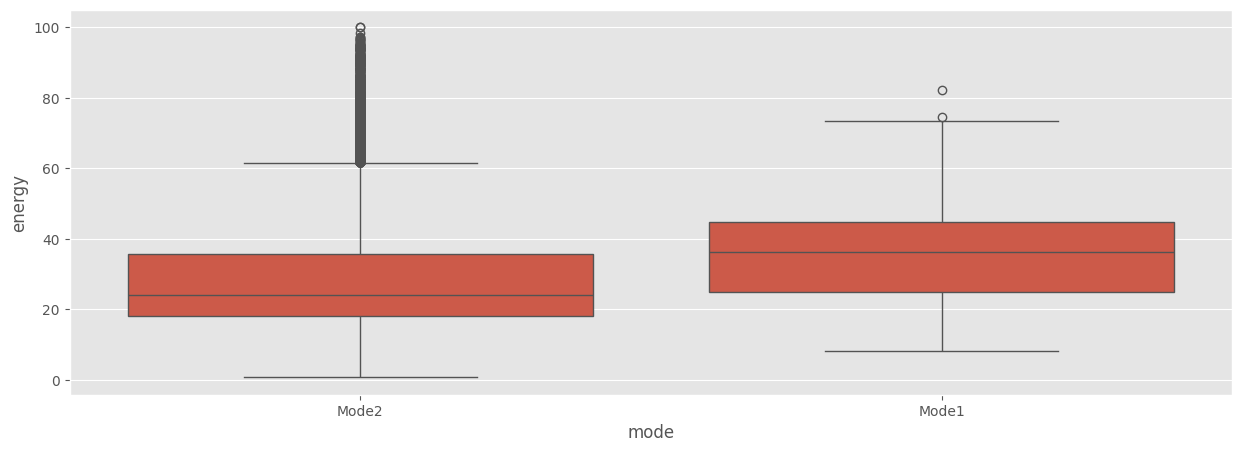

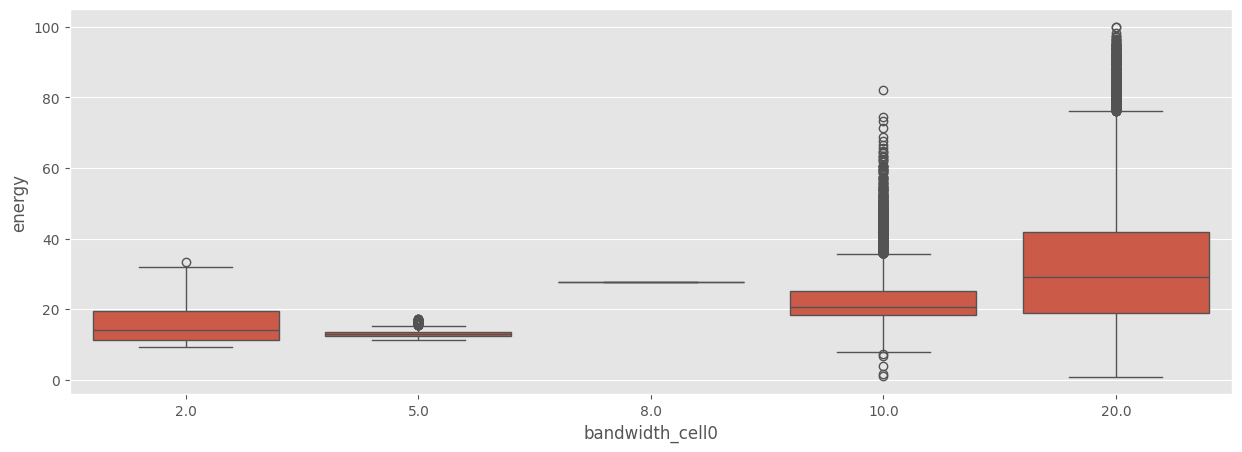

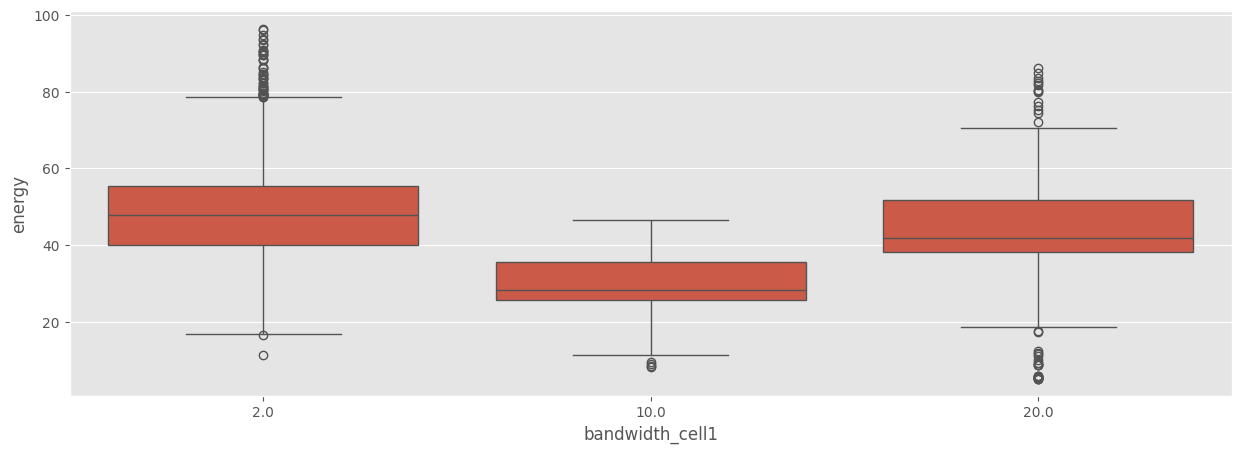

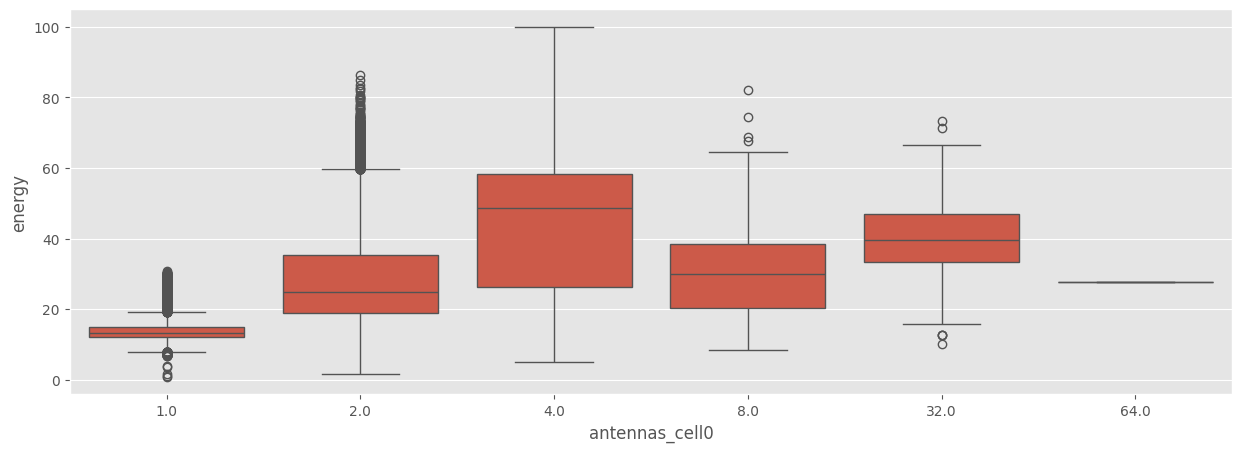

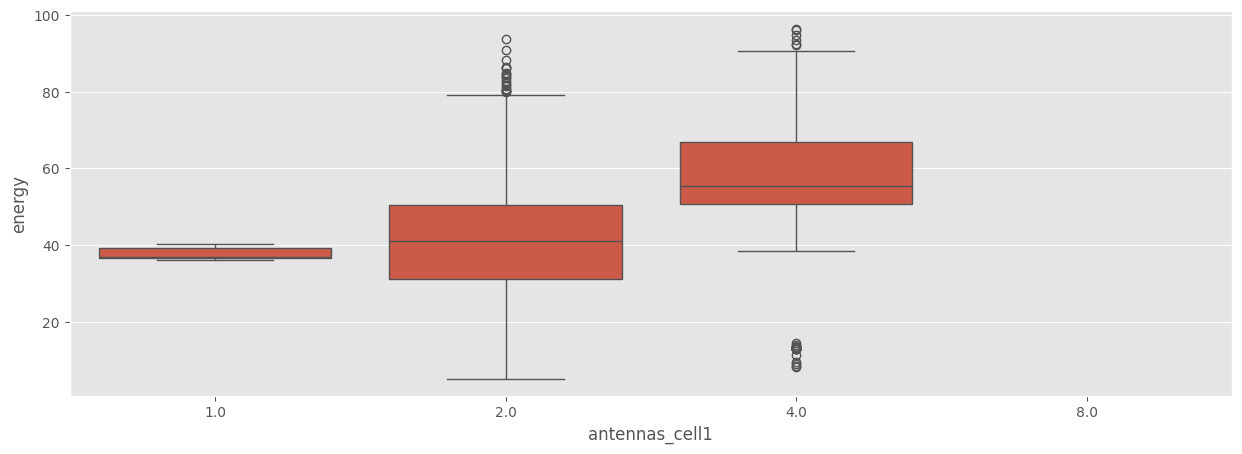

In [89]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df, x=fe, y='energy')
    plt.show()

In [90]:
def plot_cat_train_test_dist(df, fe_name, hue='split'):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the distribution plot on the first subplot
    sns.countplot(data=df[df['split'] == 'train'], ax=axes[0], x=fe_name)
    axes[0].set_title('Train Count Plot')

    # Plot the box plot on the second subplot
    sns.countplot(data=df[df['split'] == 'test'], ax=axes[1], x=fe_name)
    axes[1].set_title('Test Count Plot')

    sns.countplot(data=df, ax=axes[2], x=fe_name, hue='split')
    axes[2].set_title('Train & Test Count Plot')

    plt.show()

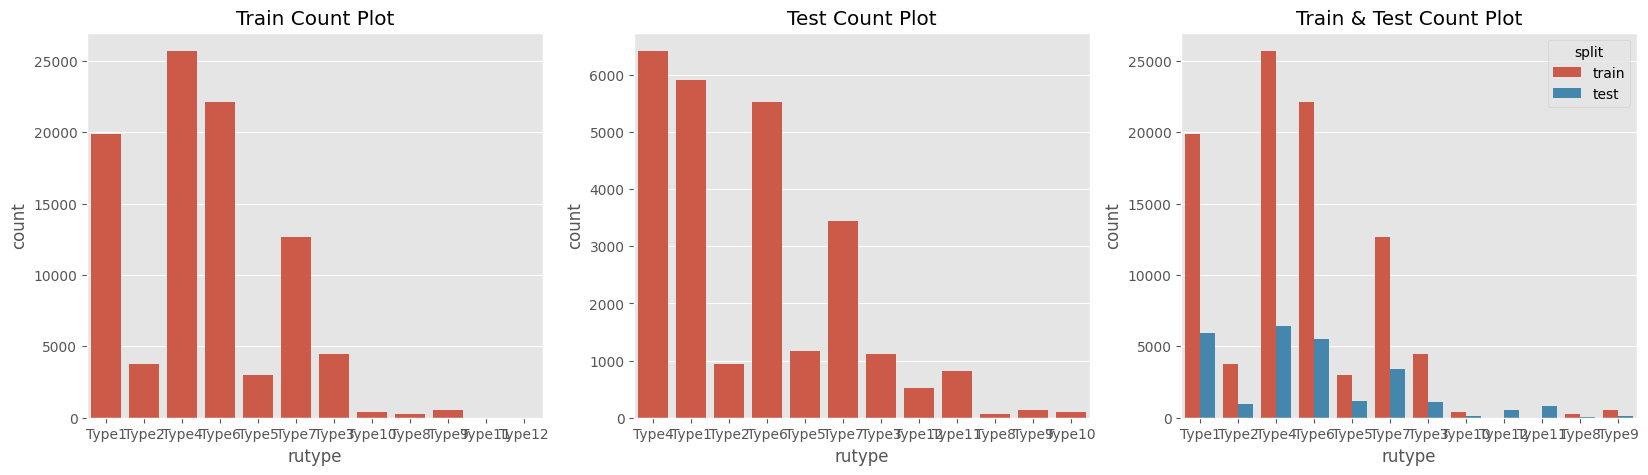

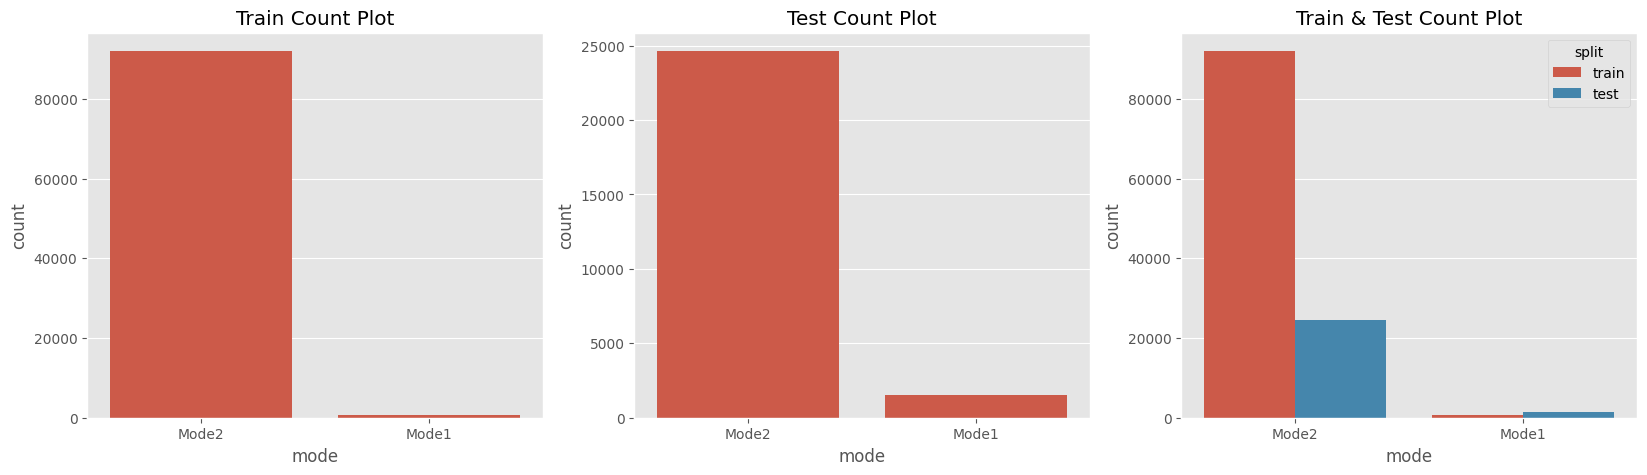

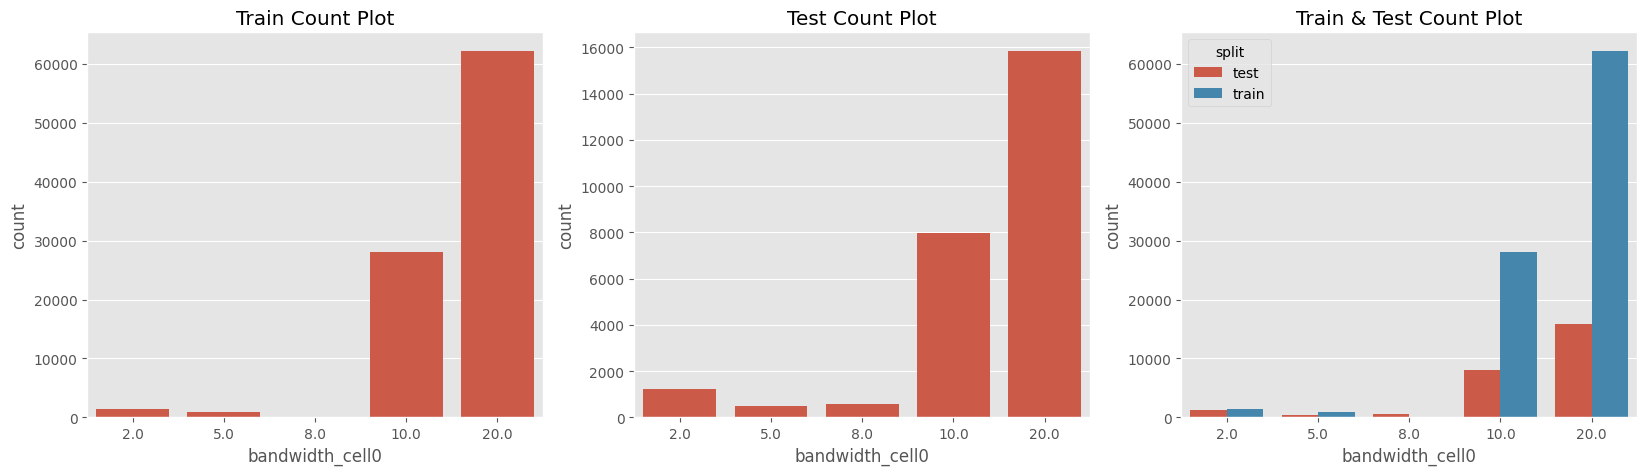

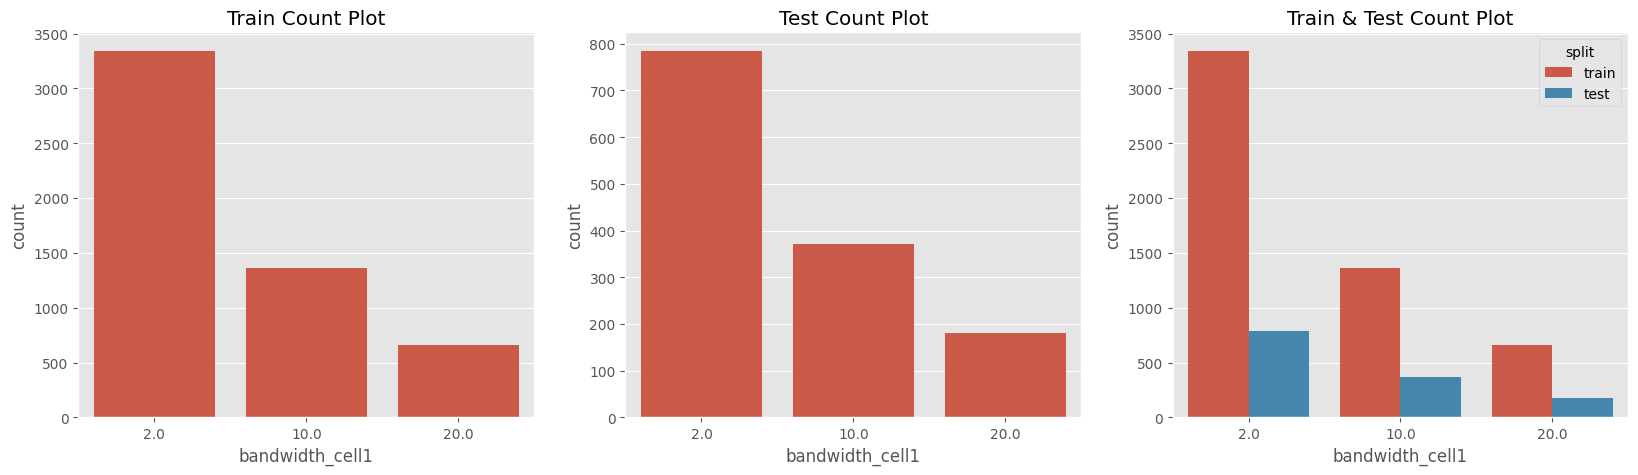

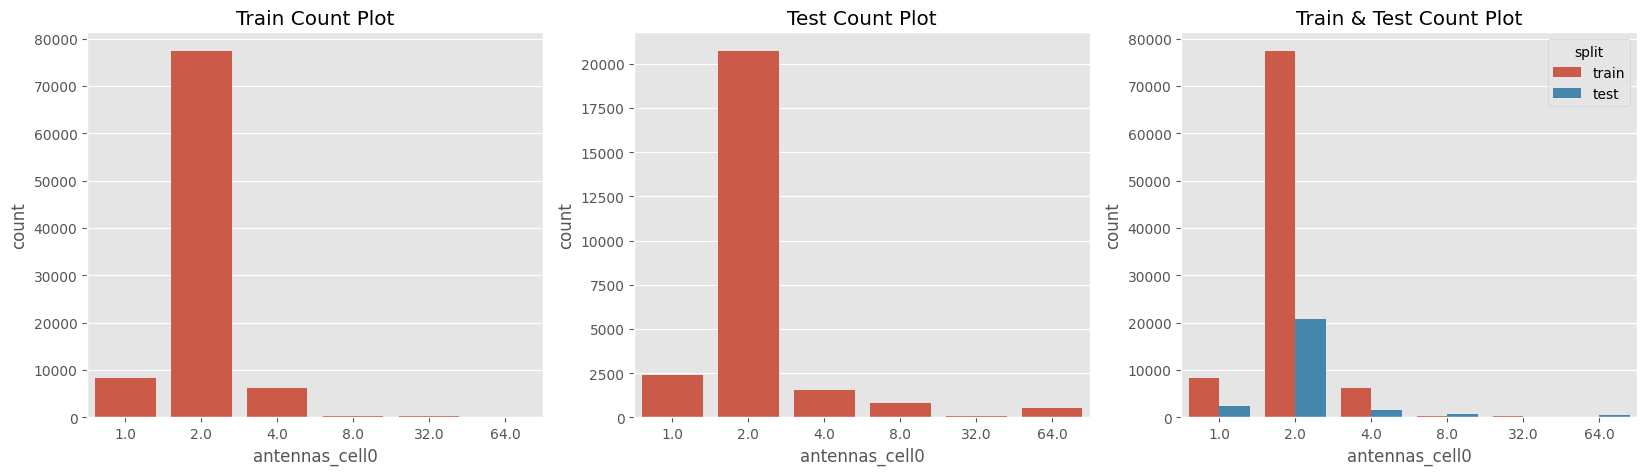

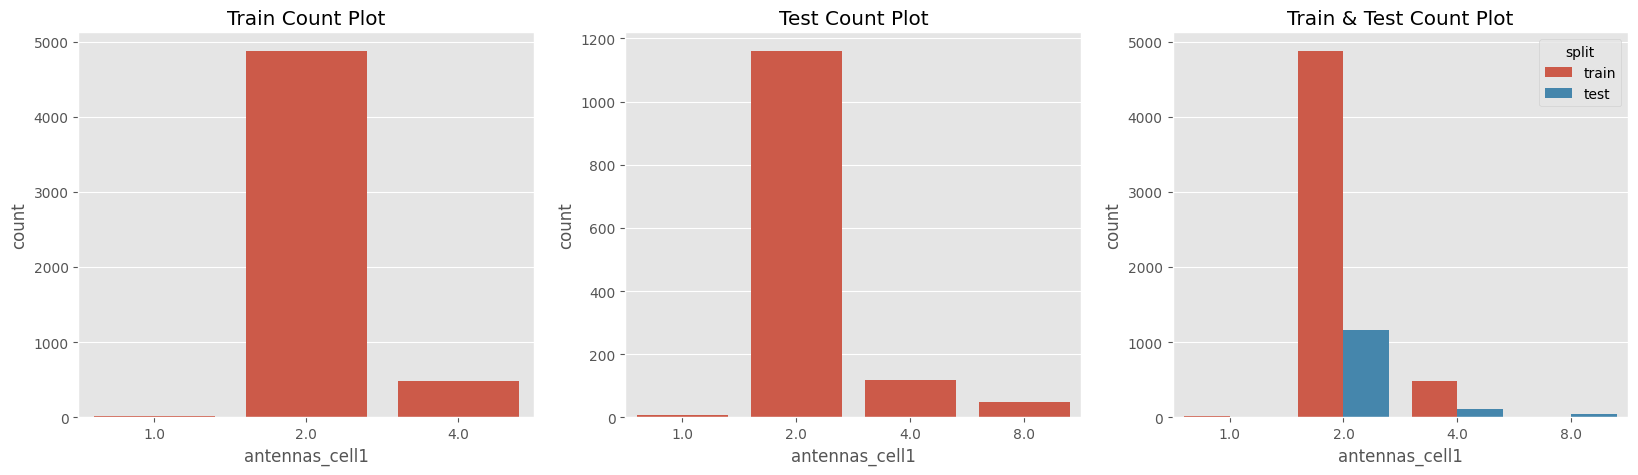

In [26]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plot_cat_train_test_dist(df=df, fe_name=fe, hue='split')

In [95]:
# df.head()
df.groupby("split")['rutype'].value_counts().sort_index()

split  rutype
test   Type1      5908
       Type10      101
       Type11      815
       Type12      527
       Type2       939
       Type3      1111
       Type4      6419
       Type5      1164
       Type6      5521
       Type7      3446
       Type8        58
       Type9       130
train  Type1     19902
       Type10      403
       Type11        1
       Type12        1
       Type2      3757
       Type3      4442
       Type4     25677
       Type5      2974
       Type6     22083
       Type7     12641
       Type8       230
       Type9       518
Name: count, dtype: int64

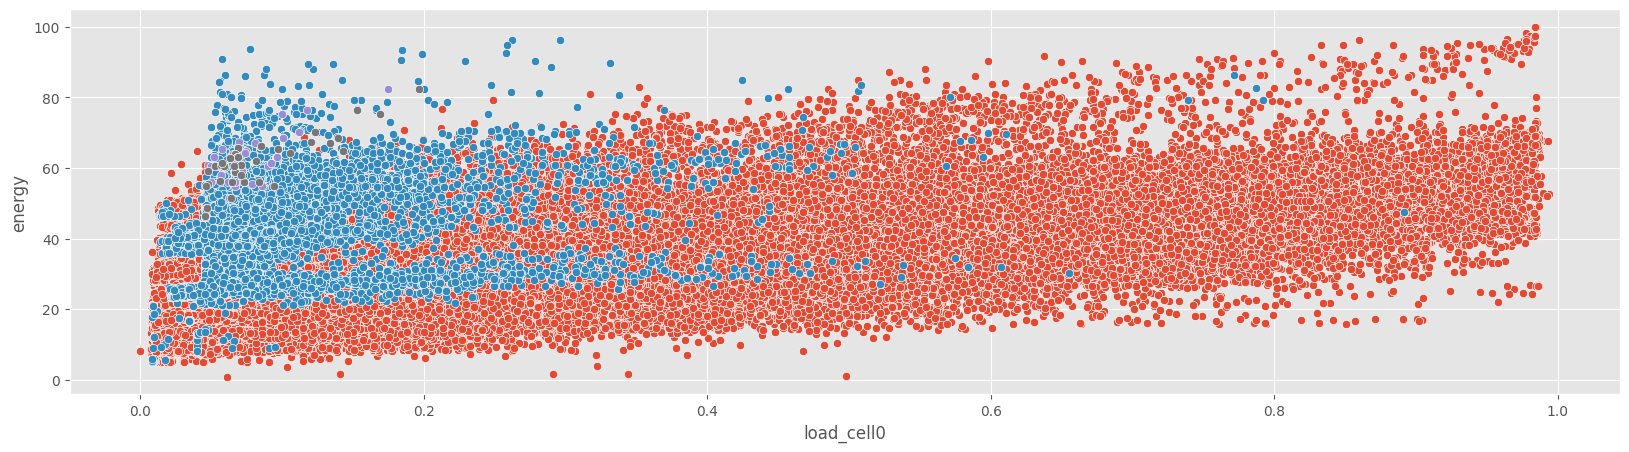

In [96]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell3', y='energy')
plt.show()

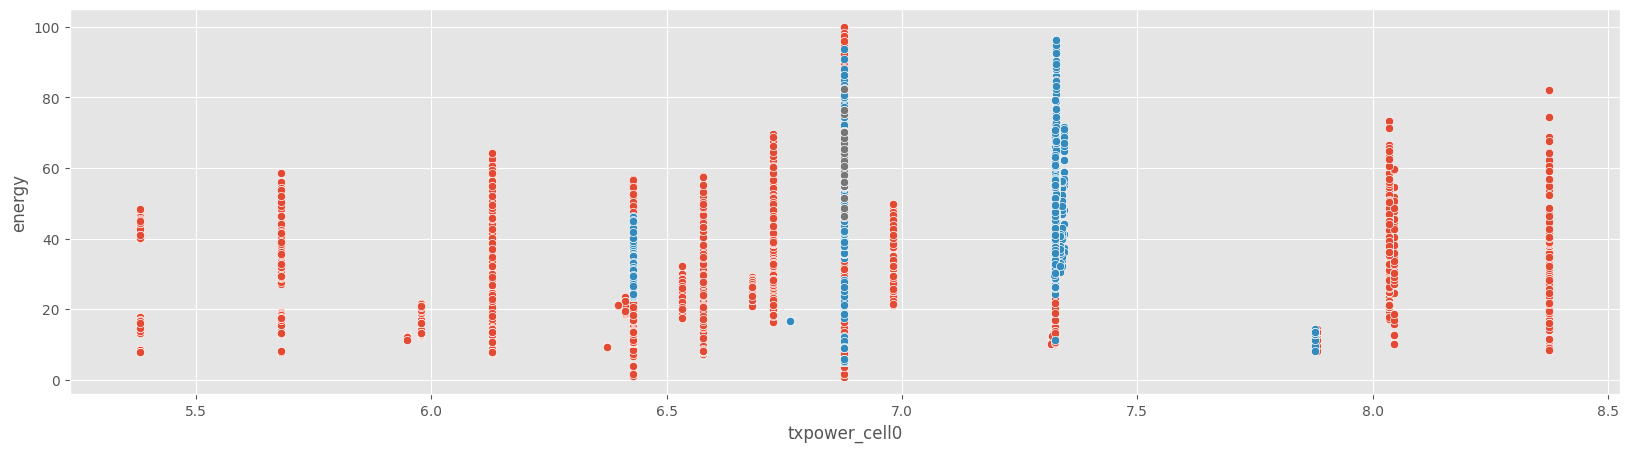

In [97]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell3', y='energy')
plt.show()

# Modelling

In [98]:
train_data = df[df['split'] =='train']
test_data = df[df['split'] =='test']

train_data.shape, test_data.shape

((92629, 50), (26139, 50))

In [100]:
def feature_engineering(train_df, valid_df, test_df):

    train_df['hour'] = train_df['time'].dt.hour
    valid_df['hour'] = valid_df['time'].dt.hour
    test_df['hour'] = test_df['time'].dt.hour

    # target_encoder = TargetEncoder(min_samples_leaf=1)
    # train_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.fit_transform(X=train_df[['rutype', 'mode', 'hour', 'bs']], y=train_df['energy'])
    # valid_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.transform(X=valid_df[['rutype', 'mode', 'hour', 'bs']])
    # test_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.transform(X=test_df[['rutype', 'mode', 'hour', 'bs']])

    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    df['bs_en'] = df['bs'].apply(lambda x: int(x.strip('B_')))

    # df['rutype'] = df['rutype'].apply(lambda x: int(x.strip('Type')))
    # df['mode'] = df['mode'].apply(lambda x: int(x.strip('Mode')))

    df = pd.get_dummies(df, columns=['rutype',  'mode', 'hour'])

    df.sort_values(['time', 'bs'], inplace=True)
    # for fe in ['antennas_cell0', 'antennas_cell1', 'antennas_cell2', 'antennas_cell3', 'load_cell0', 'load_cell1',
    #    'load_cell2', 'load_cell3', 'txpower_cell0', 'txpower_cell1', 'txpower_cell2', 'txpower_cell3']:
    #     for r in [3, 5, 8, 10, 15]:
    #         df[f'r{r}_mean_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).mean())
    #         df[f'r{r}_std_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).std())
    #         df[f'r{r}_skew_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).skew())
    #         df[f'r{r}_max_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).max())

    # Target rolling
    # for fe in ['energy']:
    #     for r in [3, 5, 8, 10, 15]:
    #         df[f'r{r}_mean_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).mean().shift(1))
    #         df[f'r{r}_std_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).std().shift(1))
    #         df[f'r{r}_skew_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).skew().shift(1))
    #         df[f'r{r}_max_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).max().shift(1))


    train_df = df[df['split'] =='train']
    valid_df = df[df['split'] =='valid']
    test_df = df[df['split'] =='test']

    return train_df, valid_df, test_df

In [101]:
target_col = 'energy'
drop_cols = ['time', 'bs', 'split', target_col]

In [102]:
kf = model_selection.KFold(n_splits=5)
print(kf)
kf = kf.split(X=train_data)
print(kf)

oof_valid_preds = np.zeros(train_data.shape[0], )
test_preds_list = []

for i, (train_idx, valid_idx) in enumerate(kf):

    train_df = train_data.iloc[train_idx]
    valid_df = train_data.iloc[valid_idx]
    test_df = test_data.copy()

    train_df, valid_df, test_df = feature_engineering(train_df=train_df, valid_df=valid_df, test_df=test_df)
    train_cols = [col for col in train_df.columns if col not in drop_cols]

    X_train, y_train = train_df[train_cols], train_df[target_col]
    X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
    X_test = test_df[train_cols]

    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        # 'learning_rate': 0.01,
        'n_jobs': -1,
        'max_depth' : -1,
        'metric': 'mae',
        'num_boost_round': 10000,
    }

    model = lgb.LGBMRegressor(**params)

    early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping_callback, verbose_callback],
    )

    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)

    val_score = metrics.mean_absolute_error(y_valid, valid_preds)
    oof_valid_preds[valid_idx] = valid_preds
    test_preds_list.append(test_preds)

    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Valid score : ", val_score)

oof_score = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds)
print("_-*"*50)
print(f"OOF score : ", oof_score)

[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2019
[LightGBM] [Info] Number of data points in the train set: 74103, number of used features: 79
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 28.313705
[100]	valid_0's l1: 2.05555
[200]	valid_0's l1: 1.85915
[300]	valid_0's l1: 1.76632
[400]	valid_0's l1: 1.69355
[500]	valid_0's l1: 1.63654
[600]	valid_0's l1: 1.59842
[700]	valid_0's l1: 1.56794
[800]	valid_0's l1: 1.54407
[900]	valid_0's l1: 1.52814
[1000]	valid_0's l1: 1.51438
[1100]	valid_0's l1: 1.50058
[1200]	valid_0's l1: 1.49275
[130

KeyboardInterrupt: 

In [34]:
test_preds_list

[array([15.43070238, 46.30730906, 19.22536472, ..., 19.16077274,
        20.12503039, 37.38867166]),
 array([16.29839829, 47.64572212, 18.25227204, ..., 18.85286516,
        20.91558253, 37.42780025]),
 array([15.70159102, 46.70625555, 18.54344248, ..., 18.42522982,
        20.44719378, 37.11533815]),
 array([16.20969123, 46.1642308 , 18.72173563, ..., 18.53151024,
        20.44104586, 37.05793505]),
 array([15.22810705, 47.31505769, 18.08830937, ..., 18.33827922,
        20.57796283, 37.20023528])]

In [35]:
test_preds_mean = np.mean(test_preds_list, axis=0)

In [36]:
test_preds_mean

array([15.77369799, 46.82771504, 18.56622485, ..., 18.66173144,
       20.50136308, 37.23799608])

<Axes: >

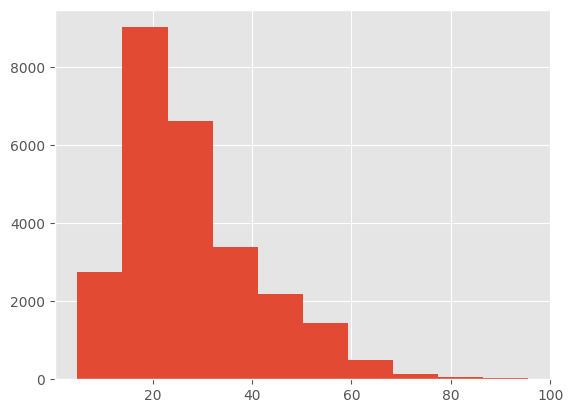

In [37]:
test_data['Energy'] = test_preds_mean
test_data['Energy'].hist()

In [38]:
sample_submission.head()

,ID,Energy
0,2023-01-01 06:00:00_B_0,0
1,2023-01-01 11:00:00_B_0,0
2,2023-01-01 12:00:00_B_0,0
3,2023-01-01 13:00:00_B_0,0
4,2023-01-01 23:00:00_B_0,0


In [39]:
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']

In [40]:
test_data[['ID', 'Energy']]

,ID,Energy
3,2023-01-01 01:00:00_B_100,15.773698
8,2023-01-01 01:00:00_B_105,46.827715
10,2023-01-01 01:00:00_B_107,18.566225
15,2023-01-01 01:00:00_B_111,34.288705
18,2023-01-01 01:00:00_B_114,24.332797
...,...,...
118757,2023-01-08 00:00:00_B_786,26.459958
118761,2023-01-08 00:00:00_B_790,20.751127
118762,2023-01-08 00:00:00_B_791,18.661731
118763,2023-01-08 00:00:00_B_792,20.501363


In [41]:
sample_submission = sample_submission[['ID']]
sample_submission = sample_submission .merge(test_data[['ID', 'Energy']], on='ID', how='left')

In [42]:
sample_submission.to_csv("base_model_submission.csv", index=False)
